=== Classification Report ===
              precision    recall  f1-score   support

        diri       1.00      1.00      1.00        48
       duduk       1.00      1.00      1.00        46
       tidur       1.00      1.00      1.00        47

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



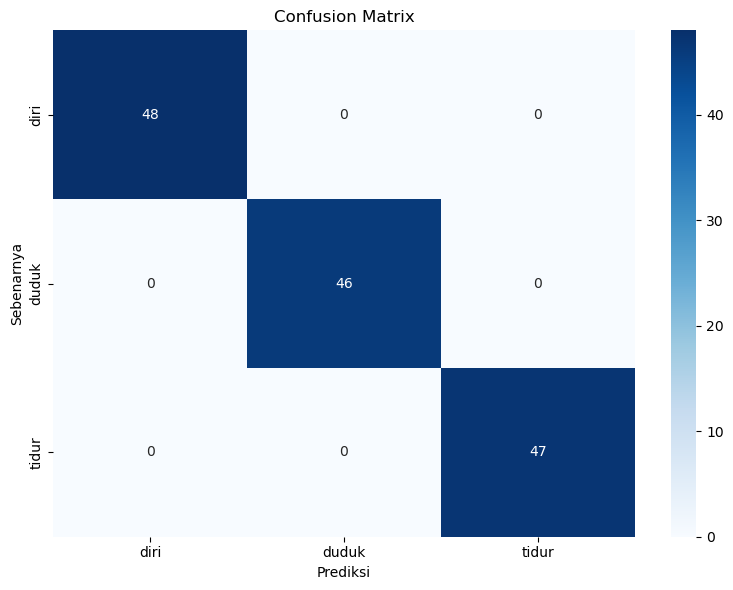

In [1]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical

from imblearn.over_sampling import SMOTE
from scipy.stats import mode

import tensorflow as tf
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

# --- 1. Load data ---
df = pd.read_csv('data_3aktv.csv')

# --- 2. Hitung magnitudo accelerometer dan gyroscope ---
features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

# --- 3. Label Encoding ---
label_encoder = LabelEncoder()
df['encoded_activity'] = label_encoder.fit_transform(df['activity'])

X = df[features].values
y_encoded = df['encoded_activity'].values

# --- 4. Sliding Window ---
def create_windows(X, y, window_size=100, step=50):
    Xs, ys = [], []
    for start in range(0, len(X) - window_size + 1, step):
        end = start + window_size
        Xs.append(X[start:end])
        window_labels = y[start:end]
        counts = np.bincount(window_labels)
        ys.append(np.argmax(counts))
    return np.array(Xs), np.array(ys)


X_windows, y_windows = create_windows(X, y_encoded)

# --- 5. Split data sebelum normalisasi dan balancing ---
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_windows, test_size=0.2, stratify=y_windows, random_state=42
)

# --- 6. Normalisasi ---
scaler = StandardScaler()

# reshape ke 2D untuk fit scaler
X_train_shape = X_train.shape
X_train_2d = X_train.reshape(-1, X_train_shape[2])
X_train_2d = scaler.fit_transform(X_train_2d)
X_train = X_train_2d.reshape(X_train_shape)

X_test_shape = X_test.shape
X_test_2d = X_test.reshape(-1, X_test_shape[2])
X_test_2d = scaler.transform(X_test_2d)
X_test = X_test_2d.reshape(X_test_shape)

from sklearn.ensemble import RandomForestClassifier

# --- 7. Flatten window (3D → 2D) untuk Random Forest ---
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# --- 8. Training Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

# --- 9. Evaluasi ---
y_pred = rf_model.predict(X_test_flat)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# --- 10. Confusion Matrix ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Prediksi")
plt.ylabel("Sebenarnya")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



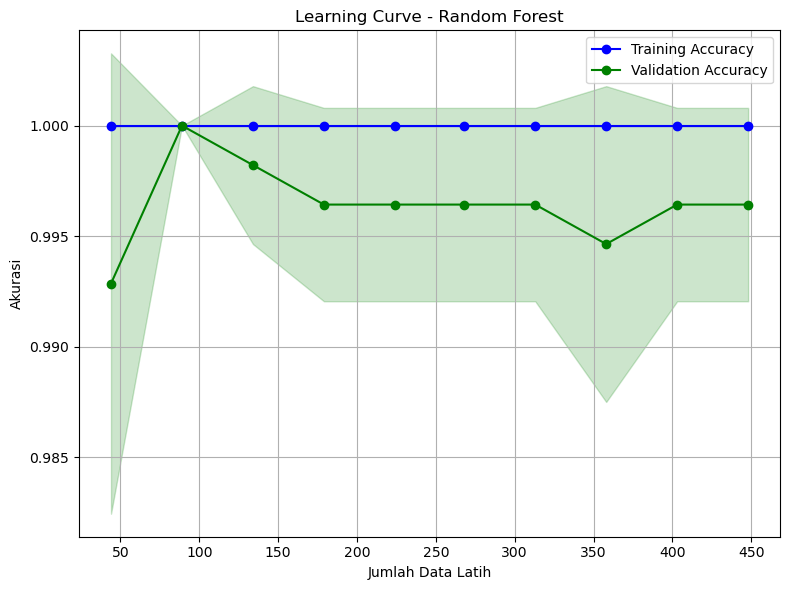

In [3]:
from sklearn.model_selection import learning_curve

# --- 11. Learning Curve ---
train_sizes, train_scores, test_scores = learning_curve(
    rf_model,
    X_train_flat,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Hitung rata-rata dan standar deviasi dari skor
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# --- 12. Plot Learning Curve ---
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

plt.title('Learning Curve - Random Forest')
plt.xlabel('Jumlah Data Latih')
plt.ylabel('Akurasi')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
